## XGB Experiments

In [ ]:
#Google colab was used and results were ran again on 5 July to retrieve the pkl files for submission as supporting docs. 

In [20]:
!pip install gensim
!pip install optuna

In [21]:
!pip install evaluate

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib
from xgboost import XGBClassifier

In [23]:
random.seed(42)
np.random.seed(42)

- Load the train and test files

In [25]:
train_df = pd.read_csv("/content/drive/My Drive/AMLProject/train_data.csv")
val_df  = pd.read_csv("/content/drive/My Drive/AMLProject/val_data.csv")
test_df  = pd.read_csv("/content/drive/My Drive/AMLProject/test_data.csv")


import pandas as pd

In [26]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## DistilBERT (Extract embeddings using fine-tuned DistilBERT w preprocessing)

In [27]:
import pandas as pd
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.nn import CrossEntropyLoss
import evaluate
from sklearn.metrics import accuracy_score, classification_report
import torch
from transformers import AutoTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Text preprocessing

In [28]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

In [29]:
train_texts = train_df["text"].astype(str).apply(preprocess_text).tolist()
val_texts   = val_df["text"].astype(str).apply(preprocess_text).tolist()
train_labels = train_df["sentiment_id"].tolist()
val_labels   = val_df["sentiment_id"].tolist()

- Fine-tuning DistilBERT

In [30]:
cuda_available = torch.cuda.is_available()
mps_available  = getattr(torch.backends.mps, "is_available", lambda: False)()

if cuda_available:
    device = "cuda"
elif mps_available:
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: cuda


In [31]:
# compute balanced class weights
classes = np.unique(train_labels)
weights = compute_class_weight("balanced", classes=classes, y=train_labels)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

In [32]:
# tokenize
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, padding=True, truncation=True)
val_encodings   = tokenizer(val_texts,   padding=True, truncation=True)

In [33]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)

In [34]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")
metric_f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = metric_accuracy.compute(predictions=preds, references=labels)["accuracy"]
    prec = metric_precision.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["precision"]
    rec = metric_recall.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["recall"]
    f1 = metric_f1.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]


    return {
        "Accuracy":  acc,
        "Precision": prec,
        "Recall":    rec,
        "F1":        f1,
    }

In [35]:
training_args = TrainingArguments(
    output_dir='./results_distilbert_experiment3',
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    greater_is_better=True,
    logging_dir="./logs",
)

In [36]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

In [38]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.781100,0.665173,0.798000,0.632606,0.699557,0.655385
2,0.592600,0.699596,0.853000,0.714384,0.743035,0.724951
3,0.421800,0.922224,0.860000,0.719047,0.736013,0.725270


TrainOutput(global_step=3000, training_loss=0.5984860636393229, metrics={'train_runtime': 1109.4331, 'train_samples_per_second': 21.633, 'train_steps_per_second': 2.704, 'total_flos': 3179274264576000.0, 'train_loss': 0.5984860636393229, 'epoch': 3.0})

In [40]:
# save best model and tokenizer
trainer.save_model("distilbert_experiment3")
tokenizer.save_pretrained("distilbert_experiment3")

('distilbert_experiment3/tokenizer_config.json',
 'distilbert_experiment3/special_tokens_map.json',
 'distilbert_experiment3/vocab.txt',
 'distilbert_experiment3/added_tokens.json',
 'distilbert_experiment3/tokenizer.json')

In [41]:
model     = DistilBertForSequenceClassification.from_pretrained("distilbert_experiment3").to(device)
tokenizer = AutoTokenizer.from_pretrained("distilbert_experiment3")

inference_trainer = Trainer(
    model=model,
    tokenizer=tokenizer)

/tmp/ipython-input-41-3612386086.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  inference_trainer = Trainer(


In [42]:
# Run predict on validation dataset
pred_output = inference_trainer.predict(val_dataset)

# compute predictions
logits = pred_output.predictions
y_true = pred_output.label_ids
y_pred = np.argmax(logits, axis=1)

# classification report
print(classification_report(y_true,y_pred,target_names=["Negative", "Neutral", "Positive"],digits=4))

              precision    recall  f1-score   support

    Negative     0.7778    0.7438    0.7604       160
     Neutral     0.4252    0.5347    0.4737       101
    Positive     0.9542    0.9296    0.9417       739

    accuracy                         0.8600      1000
   macro avg     0.7190    0.7360    0.7253      1000
weighted avg     0.8725    0.8600    0.8654      1000



- Extract train and validation embeddings using fine-tuned model

In [43]:
# reload fine-tuned tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert_experiment3")
model     = DistilBertForSequenceClassification.from_pretrained("distilbert_experiment3").to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [44]:
def get_embeddings(texts, batch_size=32):
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(batch, return_tensors="pt",
                        padding=True, truncation=True).to(device)
        with torch.no_grad():
            out = model.distilbert(**enc) # run the encoder of fine-tuned distilbert
        cls_emb = out.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeds.append(cls_emb)
    return np.vstack(all_embeds)

In [45]:
X_train_embeds_1 = get_embeddings(train_texts)
joblib.dump(X_train_embeds_1, "X_train_embeds_distilbert_finetuned_experiment3.pkl")

['X_train_embeds_distilbert_finetuned_experiment3.pkl']

In [47]:
X_val_embeds_1   = get_embeddings(val_texts)
joblib.dump(X_val_embeds_1,   "X_val_embeds_distilbert_finetuned_experiment3.pkl")

['X_val_embeds_distilbert_finetuned_experiment3.pkl']

- Hyperparameter Tuning

In [49]:
X_train_embeds_1 = joblib.load("X_train_embeds_distilbert_finetuned_experiment3.pkl")
X_val_embeds_1   = joblib.load("X_val_embeds_distilbert_finetuned_experiment3.pkl")

In [50]:
y_train = train_df["sentiment_id"]
y_val   = val_df  ["sentiment_id"]

In [51]:
def objective(trial):
    # XGBoost hyperparameters
    params = {
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "random_state": 42,
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0)
    }

    clf = XGBClassifier(**params)
    clf.fit(X_train_embeds_1, y_train)
    preds = clf.predict(X_val_embeds_1)

    return f1_score(y_val, preds, average="macro")

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Output results
print("Best macro-F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-07-04 20:20:46,906] A new study created in memory with name: no-name-f04613ec-b9e2-4cab-ac1d-df8633138c0e
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-04 20:20:55,660] Trial 0 finished with value: 0.7210991669421599 and parameters: {'n_estimators': 152, 'max_depth': 3, 'learning_rate': 0.1709392691436783, 'subsample': 0.6448420696544404, 'colsample_bytree': 0.7508729739130086, 'reg_alpha': 0.42082613746748665, 'reg_lambda': 0.4014360487947233}. Best is trial 0 with value: 0.7210991669421599.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-07-04 20:21:37,459] Trial 1 finished with value: 0.7295143304807471 and parameters: {'n_estimator

Best macro-F1: 0.7295143304807471
Best hyperparameters:
  n_estimators: 152
  max_depth: 10
  learning_rate: 0.11610454641524287
  subsample: 0.7644781271620026
  colsample_bytree: 0.9494334476231512
  reg_alpha: 0.8477758678288546
  reg_lambda: 0.8195469928237021


- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [52]:
test_texts = test_df["text"].tolist()
y_test     = test_df["sentiment_id"].values

In [53]:
X_test_embeds_1 = get_embeddings(test_texts, batch_size=32)
joblib.dump(X_test_embeds_1,   "X_test_embeds_distilbert_finetuned_experiment3.pkl")

['X_test_embeds_distilbert_finetuned_experiment3.pkl']

In [55]:
# retreive train and test set embeddings
X_train_embeds_1 = joblib.load("X_train_embeds_distilbert_finetuned_experiment3.pkl")
X_test_embeds_1 = joblib.load("X_test_embeds_distilbert_finetuned_experiment3.pkl")

# Train XGB
XGB_distilbert_1 = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_estimators=89,         # replaced with tuned values below
    max_depth=8,
    learning_rate=0.03401308510685299,
    subsample=0.8612803675356533,
    colsample_bytree=0.9456299916111127,
    reg_alpha=0.730185839070075,
    reg_lambda=0.8685274337503665
)
XGB_distilbert_1.fit(X_train_embeds_1, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:25:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9456299916111127, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03401308510685299,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=89, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [56]:
test_preds_1 = XGB_distilbert_1.predict(X_test_embeds_1)

print(classification_report(
    y_test,
    test_preds_1,
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.85      0.66      0.74       160
     Neutral       0.48      0.64      0.55       101
    Positive       0.95      0.95      0.95       739

    accuracy                           0.87      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.88      0.87      0.88      1000



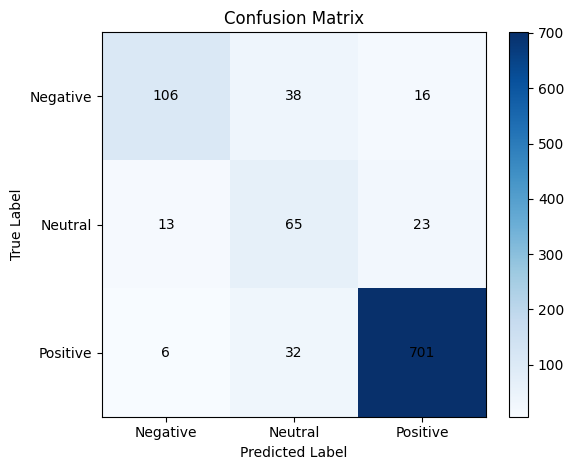

In [57]:
cm = confusion_matrix(test_df["sentiment_id"], test_preds_1)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [58]:
# Save the trained model
joblib.dump(XGB_distilbert_1, "XGB_finetuned_distilbert_experiment3.pkl")

['XGB_finetuned_distilbert_experiment3.pkl']

In [60]:
# Add predictions as a new column
test_df["FT_distilbert_pred"] = test_preds_1

# Save to CSV
test_df.to_csv("FT_distilbert_preds_experiment3.csv", index=False)

### Save full pipeline

In [61]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

XGB_distilbert_1 = joblib.load("XGB_finetuned_distilbert_experiment3.pkl")

class DistilBertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return get_embeddings(list(X), batch_size=self.batch_size)

pipeline_full = Pipeline([
    ("embed", DistilBertVectorizer(batch_size=32)),
    ("clf",   XGB_distilbert_1)
])

joblib.dump(pipeline_full, "distilbert_XGB_full_pipeline_experiment3.pkl")
print("Saved end-to-end pipeline to 'distilbert_XGB_full_pipeline_experiment3.pkl'")

Saved end-to-end pipeline to 'distilbert_XGB_full_pipeline_experiment3.pkl'
